# Figures 3-4

This notebook produces Figures 3-4 and other auxiliary figures.       

## Get data

(1) From Felikson et al.: Inland limits to diffusion of thinning along Greenland Ice Sheet outlet glaciers, available at https://zenodo.org/record/4284759. Redistributed under the CC-BY-4.0 License (see the previous link for details).

Reference: Felikson, D., A. Catania, G., Bartholomaus, T. C., Morlighem, M., & Noël, B. P. Y. (2021). Steep Glacier Bed Knickpoints Mitigate Inland Thinning in Greenland. Geophysical Research Letters, 48(2), 1–10. https://doi.org/10.1029/2020GL090112

In [1]:
%%bash

if [ ! -d ../data/Felikson2021/ ]; then
    wget https://zenodo.org/record/4284759/files/netcdfs.zip -P ../data/Felikson2021/ --no-verbose
    unzip ../data/Felikson2021/netcdfs.zip -d ../data/Felikson2021/
    rm -rf ../data/Felikson2021/netcdfs.zip
fi

(2) From ITS_LIVE: A NASA MEaSUREs project to provide automated, low latency, global glacier flow and elevation change datasets. Original data available at https://its-live.jpl.nasa.gov/. We manually made the file for the 2018-1998 speed difference.

References: 

1. Gardner, A. S., M. A. Fahnestock, and T. A. Scambos (2019) [Accessed October 21, 2021]. ITS_LIVE Regional Glacier and Ice Sheet Surface Velocities. Data archived at National Snow and Ice Data Center. https://doi.org/10.5067/6II6VW8LLWJ7
2. Gardner, A. S., G. Moholdt, T. Scambos, M. Fahnstock, S. Ligtenberg, M. van den Broeke, and J. Nilsson (2018). Increased West Antarctic and unchanged East Antarctic ice discharge over the last 7 years, Cryosphere, 12(2), 521–547. https://doi.org/10.5194/tc-12-521-2018

In [2]:
%%bash

if [ ! -f ../data/GRE_G0240_1998_v.tif ]; then
    wget https://github.com/whyjz/pejzero/releases/download/v0.1/GRE_G0240_1998_v.tif -P ../data/ --no-verbose
    wget https://github.com/whyjz/pejzero/releases/download/v0.1/GRE_G0240_diff-2018-1998_v.tif -P ../data/ --no-verbose
fi

## Analysis

In [3]:
import pejzero
import rasterio
from netCDF4 import Dataset
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

File locations. `glacier_file` indicates which glacier basin to look at. The default here is `/glacier0001.nc` (Jakobshavn Isbræ), but feel free to replace it with a different glacier ID. In the paper, **Figure 3** uses `/glacier0001.nc` and **Figure 4** uses `/glacier0277.nc`.

In [4]:
netcdf_dir = '../data/Felikson2021'
glacier_file = netcdf_dir + '/glacier0001.nc'
speed_file = '../data/GRE_G0240_1998_v.tif'
vdiff_file = '../data/GRE_G0240_diff-2018-1998_v.tif'

If looking at **Jakobshavn Isbræ** or **Alangordliup Sermia**, we use a customized label for figure production.

In [5]:
if '0001' in glacier_file:
    fig_label = 'glacier 0001: Jakobshavn Isbræ'
elif '0277' in glacier_file:
    fig_label = 'glacier 0277: Alangordliup Sermia'
else:
    fig_label = Path(glacier_file).stem

Open the glacier the Savitzky--Golay filterdata set and show 6 primary flowlines.

In [6]:
ds = Dataset(glacier_file, 'r')
flowline_groups, _ = pejzero.get_flowline_groups(ds)
primary_flowlines = [i for i in flowline_groups if 'iter' not in i.path]
primary_flowlines
#### Here's how to access variables in the primary_flowlines object: ####
# primary_flowlines[0]['geometry']['surface']['GIMP']['nominal']['h'][:]

[<class 'netCDF4._netCDF4.Group'>
 group /flowline03:
     dimensions(sizes): d(9563)
     variables(dimensions): float32 d(d), float32 x(d), float32 y(d)
     groups: geometry, dh, Pe, knickpoint,
 <class 'netCDF4._netCDF4.Group'>
 group /flowline04:
     dimensions(sizes): d(9985)
     variables(dimensions): float32 d(d), float32 x(d), float32 y(d)
     groups: geometry, dh, Pe, knickpoint,
 <class 'netCDF4._netCDF4.Group'>
 group /flowline05:
     dimensions(sizes): d(10559)
     variables(dimensions): float32 d(d), float32 x(d), float32 y(d)
     groups: geometry, dh, Pe, knickpoint,
 <class 'netCDF4._netCDF4.Group'>
 group /flowline06:
     dimensions(sizes): d(11056)
     variables(dimensions): float32 d(d), float32 x(d), float32 y(d)
     groups: geometry, dh, Pe, knickpoint,
 <class 'netCDF4._netCDF4.Group'>
 group /flowline07:
     dimensions(sizes): d(11241)
     variables(dimensions): float32 d(d), float32 x(d), float32 y(d)
     groups: geometry, dh, Pe, knickpoint,
 <class

Now we can calculate $P_e/\ell$ and $J_0$ for each flowline and find out the average of all 6 flowlines: 

In [7]:
results = {}

with rasterio.open(speed_file) as speed_data, rasterio.open(vdiff_file) as vdiff_data:
    for flowline_group in primary_flowlines:
        data_group = pejzero.cal_pej0_for_each_flowline(flowline_group, speed_data, vdiff_data)
        if data_group is not None:
            results[flowline_group.name] = data_group
        
results['avg'] = pejzero.cal_avg_for_each_basin(results)

`results` is a nested dict variable:
- The first layer contains results for each flowline and for the average values.
- The second layer contains all variables along the flowline distance. All variables are smoothed using the Savitzky-Golay filter (see Section 3.1) unless otherwise noted.
  - `d`: distance (km)
  - `s`: surface elevation (m)
  - `b`: bed elevation (m)
  - `u`: glacier speed from 1998 (m/yr)
  - `pe`: $P_e / \ell$ derived using Eq. 15 (1/m)
  - `j0`: $J_0$ derived using Eq. 10 (m/yr)
  - `pe_ignore_dslope`: $P_e / \ell$ derived using Eq. 16 (1/m)
  - `j0_ignore_dslope`: $J_0$ derived using Eq. 17 (m/yr)
  - `udiff`: glacier speed change between 1998 and 2018 (m/yr), unsmoothed.
  - `udiff_sm`: glacier speed change between 1998 and 2018 (m/yr), smoothed.
  - `term1`: The first term in Eq. 15 ($\frac{(m+1)\alpha_0}{mH_0}$)
  - `term2`: The second term in Eq. 15 ($-\frac{U_0'}{U_0}$)
  - `term3`: The third term in Eq. 15 ($-\frac{H_0'}{H_0}$)
  - `term4`: The fourth term in Eq. 15 ($\frac{\alpha_0'}{\alpha_0}$)
  - `term5`: The first term in Eq. 10 ($C_0 H'_0$, = `j0_ignore_dslope`)
  - `term6`: The second term in Eq. 10 ($D_0 \alpha'_0$)
  
For more information, please see the docstrings in `pejzero.py`.

In [8]:
for key in results:
    print(key)

print('--------------')
    
for key in results['flowline03']:
    print(key)

flowline03
flowline04
flowline05
flowline06
flowline07
flowline08
avg
--------------
d
s
b
u
pe
j0
term1
term2
term3
term4
term5
term6
udiff
udiff_sm
pe_ignore_dslope
j0_ignore_dslope


Now we can plot **Figure 3**:

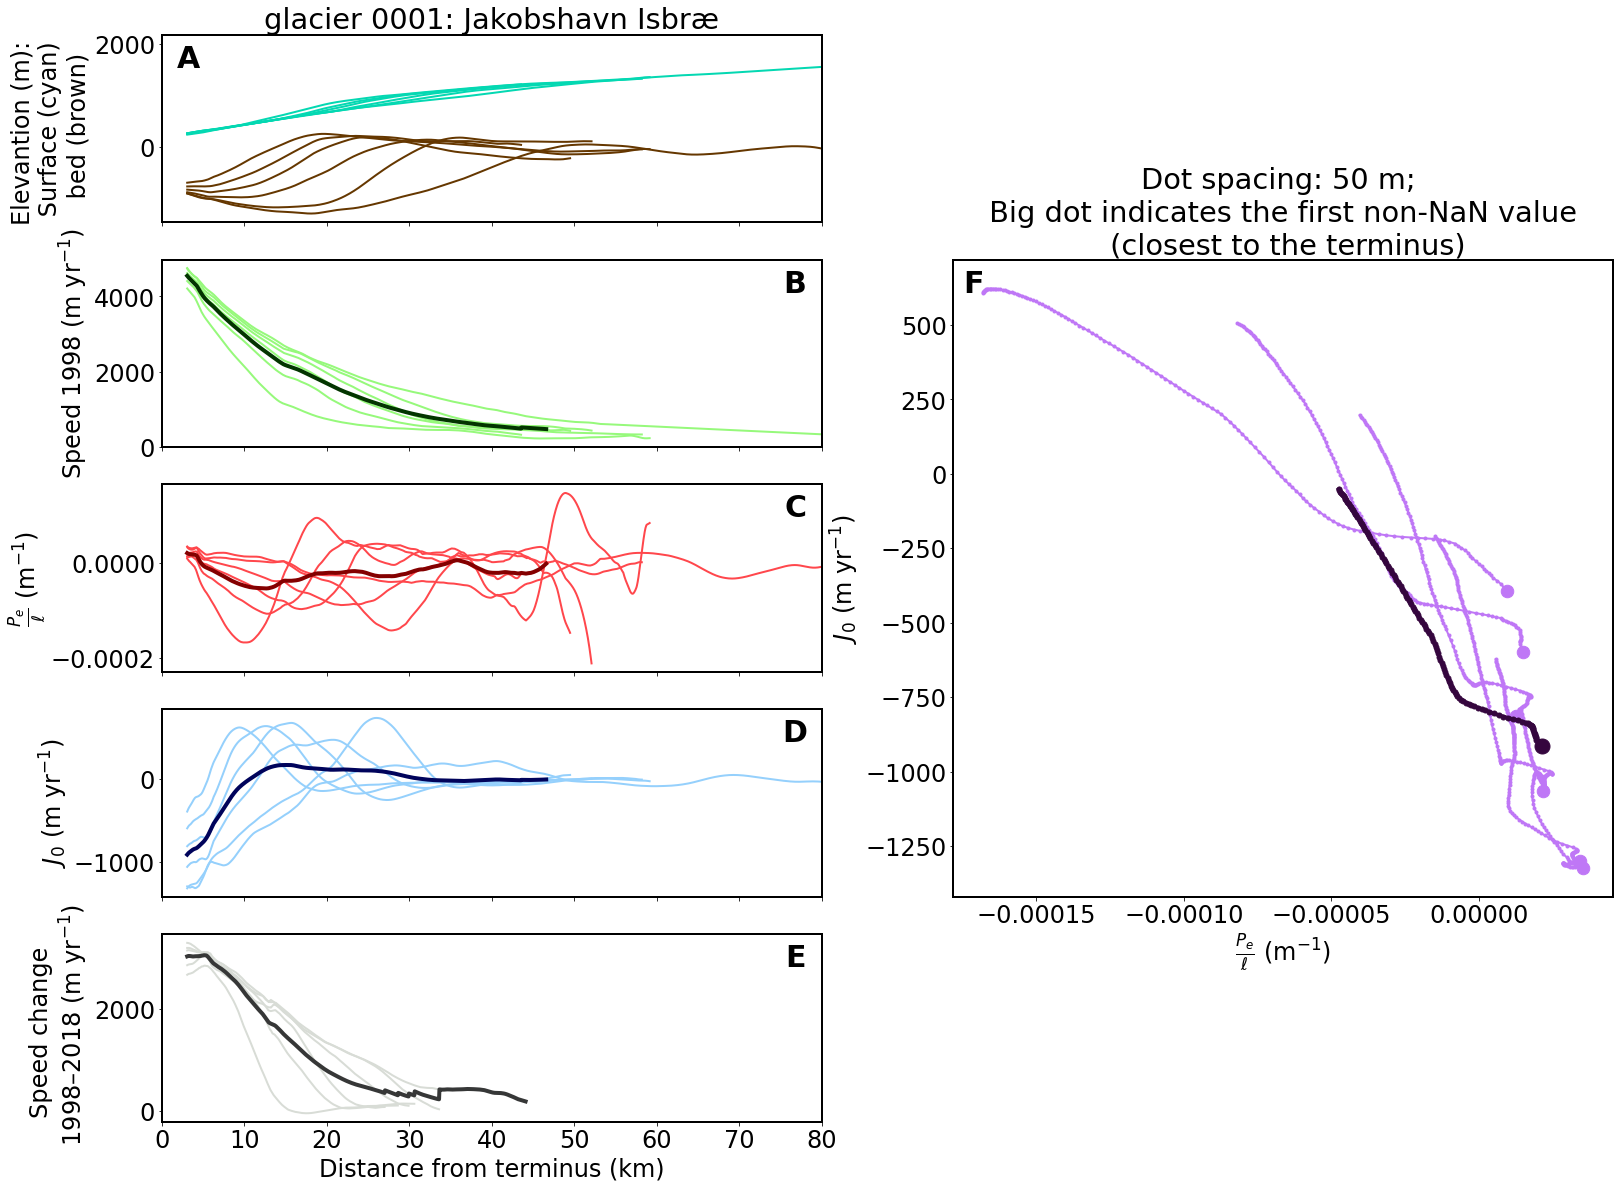

In [9]:
pej0_plot_length = 200   # This determines how many vertices from the terminus should be plotted (200 vertices = 10 km)

matplotlib.rc('font', size=24)
matplotlib.rc('axes', linewidth=2)

# ==== Create axes (5 in the left and a big one in the right)
fig, ax3 = plt.subplots(5, 2, sharex=True, figsize=(26, 20))
gs = ax3[1, 1].get_gridspec()
for ax in ax3[:, 1]:
    ax.remove()
axbig = fig.add_subplot(gs[1:4, 1])

# ==== Plot data
for key in results:
    
    if key != 'avg':   # for an individual flowline
        ax3[0, 0].plot(results[key]['d'], results[key]['s'], color='xkcd:aquamarine', linewidth=2)
        ax3[0, 0].plot(results[key]['d'], results[key]['b'], color='xkcd:brown', linewidth=2)
        ax3[1, 0].plot(results[key]['d'], results[key]['u'], color='xkcd:light green', linewidth=2)
        ax3[2, 0].plot(results[key]['d'], results[key]['pe_ignore_dslope'], color='xkcd:light red', linewidth=2)
        ax3[3, 0].plot(results[key]['d'], results[key]['j0_ignore_dslope'], color='xkcd:light blue', linewidth=2)
        ax3[4, 0].plot(results[key]['d'], results[key]['udiff_sm'], color='xkcd:light grey', linewidth=2)
        axbig.plot(results[key]['pe_ignore_dslope'][:pej0_plot_length], results[key]['j0_ignore_dslope'][:pej0_plot_length], '.-', color='xkcd:light purple', linewidth=2)
        # plot first non-NaN value (the one closest to the terminus)
        axbig.plot(next(x for x in results[key]['pe_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)),
                   next(x for x in results[key]['j0_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)), '.', color='xkcd:light purple', markersize=25)
    else:   # for the average (using different color and lind width)
        ax3[1, 0].plot(results[key]['d'], results[key]['u'], color='xkcd:dark green', linewidth=4)
        ax3[2, 0].plot(results[key]['d'], results[key]['pe_ignore_dslope'], color='xkcd:dark red', linewidth=4)
        ax3[3, 0].plot(results[key]['d'], results[key]['j0_ignore_dslope'], color='xkcd:dark blue', linewidth=4)
        ax3[4, 0].plot(results[key]['d'], results[key]['udiff_sm'], color='xkcd:dark grey', linewidth=4)
        axbig.plot(results[key]['pe_ignore_dslope'][:pej0_plot_length], results[key]['j0_ignore_dslope'][:pej0_plot_length], '.-', color='xkcd:dark purple', linewidth=4, markersize=10)
        # plot first non-NaN value (the one closest to the terminus)
        axbig.plot(next(x for x in results[key]['pe_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)),
                   next(x for x in results[key]['j0_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)), '.', color='xkcd:dark purple', markersize=30)
        
# ==== Add supplemental text and labels
letter_specs = {'fontsize': 30, 'fontweight': 'bold', 'va': 'top', 'ha': 'center'}
ax3[0, 0].set_title(fig_label)
ax3[0, 0].set_ylabel('Elevantion (m): \n Surface (cyan) \n bed (brown)')
ax3[0, 0].text(0.04, 0.95, 'A', transform=ax3[0, 0].transAxes, **letter_specs)
ax3[1, 0].set_ylabel('Speed 1998 (m yr$^{-1}$)')
ax3[1, 0].text(0.96, 0.95, 'B', transform=ax3[1, 0].transAxes, **letter_specs)
ax3[2, 0].set_ylabel(r'$\frac{P_e}{\ell}$ (m$^{-1}$)')
ax3[2, 0].text(0.96, 0.95, 'C', transform=ax3[2, 0].transAxes, **letter_specs)
ax3[3, 0].set_ylabel(r'$J_0$ (m yr$^{-1}$)')
ax3[3, 0].text(0.96, 0.95, 'D', transform=ax3[3, 0].transAxes, **letter_specs)
ax3[4, 0].set_xlabel('Distance from terminus (km)')
ax3[4, 0].set_ylabel('Speed change \n 1998–2018 (m yr$^{-1}$)')
ax3[4, 0].text(0.96, 0.95, 'E', transform=ax3[4, 0].transAxes, **letter_specs)
axbig.set_xlabel(r'$\frac{P_e}{\ell}$ (m$^{-1}$)')
axbig.set_ylabel(r'$J_0$ (m yr$^{-1}$)')
axbig.set_title('Dot spacing: 50 m; \n Big dot indicates the first non-NaN value \n (closest to the terminus)')
axbig.text(0.03, 0.985, 'F', transform=axbig.transAxes, **letter_specs)

# ==== For Figure 3 (glacier 0001 -- Jakobshavn Isbræ), we only pplot the first 80 km to highlight the change around the glacier front.
if fig_label == 'glacier 0001: Jakobshavn Isbræ':
    axbig.set_xticks([-0.00015, -0.0001, -0.00005, 0])
    ax3[4, 0].set_xlim(0, 80)

plt.savefig('../data/results/' + Path(glacier_file).stem + '.pdf')

To run the analysis in a batch mode for more than one glacier, uncomment the following cell and run `Pe-J0-Greenland-SingleBasin.py` in the for loop. The result PNGs will be saved in `../data/results/single_basins/`. You can also make it print to PDF with little modification to the last line of the script.

In [10]:
# %%bash

# filelist=`ls --color=never ../data/Felikson2021/*`
# for i in $filelist; do 
#     python Pe-J0-Greenland-SingleBasin.py $i
# done